In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os
import pandas as pd
import matplotlib.offsetbox as offsetbox

In [2]:
# Dictionary of standard (LEADER) model colours
col_dict = {'ACCESS-ESM1-5':'#7f3c8d','CanESM5':'#11a579','CMCC-CM2-SR5':'#3969ac','CNRM-CM6-1':'red','FGOALS-g3':'#f2b701','GISS-E2-1-G':'#e73f74','HadGEM3-GC31-LL':'#80ba5a','IPSL-CM6A-LR':'#e68310','MIROC6':'#008695','MPI-ESM1-2-LR':'#cf1c90','NorESM2-LM':'#f97b72'}
exp_col_dict = {"hist-totalO3": "#66c5cc",
	"hist-sol": 	"#f6cf71",
	"hist-volc":	"#f89c74",
	"unlabeled_1":  "#dcb0f2",  # rename if needed    
	"hist-aer": 	"#87c55f",
	"unlabeled_2":  "#9eb9f3",  # rename if needed
	"hist-GHG": 	"#fe88b1",
	"hist-nat": 	"#c9db74",
	"hist-total03":  "#8be0a4",  # rename if needed    
	"historical":   "#b497e7",
	"observations": "#b3b3b3"
}

In [3]:
def calculate_NAO_trend(filepath, year_init, year_final, period_init, variable, time_variable):

    #creating an empty array for the trend which will be appended to and then outputted
    #got to convert into amount of years between, there is a +1 due to python's indexing finishing before the last one (I want to include 0 and end)
    #not currently outputting the intercept but could I I need it
    NAO_trend_slope = np.zeros(year_final - year_init - period_init)
    NAO_trend_intercept = np.zeros(year_final - year_init - period_init)
    
    #opening dataset
    ds = xr.open_dataset(filepath)
    
    period_end = (year_init + period_init)
    trend_period = period_init
    i = 0

    while period_end < year_final:
        #Taking slice of dataset to perform the linregress on
        ds_slice = ds[variable].sel({time_variable: slice(year_init,year_init+trend_period)}).values
        
        # time as a simple integer array, the +1 comes from matching to the line above when slicing between initial year and initial year + trend period.        
        time_numeric = np.arange(trend_period+1)

        # Perform the regression using linregress (returns slope, intercept, r_value, p_value, std_err)
        reg_slope, reg_intercept, _, _, _ = linregress(time_numeric, ds_slice)
    
        # Store the results within the arrays made earlier
        NAO_trend_slope[i] = reg_slope
        NAO_trend_intercept[i] = reg_intercept

        #increasing the enddate, trend_period ( to update the numeric time array) and the index i.
        period_end = period_end + 1
        trend_period = trend_period + 1
        i = i + 1
        

    return NAO_trend_slope

def get_ensemble_means_timeseries_files(folder_path):
    #function which will loop through a folder (my folders are by experiment) to find all the relevant EM files
    ens_means_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if '_EM_' in filename]
    return ens_means_files

def get_multimodel_mean(files, variable):
    #this will open each file within files (list)
    #then calculate the mean across them (multimodel mean)
    #then it will output this data as an array

    data_arrays = []
    
    #looping over all files
    for file in files:
        #opening the dataset for one file
        ds = xr.open_dataset(file, engine='netcdf4')

        #appending the timeseries data to the array
        data_arrays.append(ds[variable])

    #calculating the mean
    multimodel_mean = np.mean([da.values for da in data_arrays], axis=0)

    #creating an array of the mean
    multimodel_da = xr.DataArray(multimodel_mean, coords=data_arrays[0].coords, dims=data_arrays[0].dims)

    return multimodel_da

def get_models_for_experiment(experiment):
    if experiment == 'historical':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-aer':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#'CNRM-CM6-1' to be added once CVDP EM calc
    elif experiment == 'hist-GHG':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']#'CNRM-CM6-1' to be added once CVDP EM calc
    elif experiment == 'hist-sol':
        model = ['ACCESS-ESM1-5','CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-totalO3':
        model = ['CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-volc':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    

    return model


In [22]:
#FIGURE b) DATA ANALYSIS

#times data by ten to convert into per decade?...
#Basically use the same function as before but want only to longest trend period. Make period_init biggest it can be.
year_init = 1951
year_final = 2015
period_init = year_final - year_init -1
variable = 'nao_timeseries_djf'




#calculating ERA5
filepath = '/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/ERA5_2020/ERA5_1.cvdp_data.1940-2020.nc'
era5_trend_PDF = calculate_NAO_trend(filepath, 1951, 2015, 63, variable, 'TIME') * 10
experiment = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
experiment_hist_data = {}
experiment_colours = {}

# Collect all slopes to find global min and max
all_slopes = []

for e in experiment:
    model = get_models_for_experiment(e)
    for m in model:
        folderpath = f'/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/{e}/{m}/'
        filepaths = [
            os.path.join(folderpath, filename)
            for filename in os.listdir(folderpath)
            if m in filename and '_EM_' not in filename
        ]
        for path in filepaths:
            slope = calculate_NAO_trend(path, year_init, year_final, period_init, 'psl', 'year')
            all_slopes.append(slope.item() * 10)

# Global min and max
data_min = min(all_slopes)
data_max = max(all_slopes)

# Define shared bin edges
num_bins = 25
shared_bin_edges = np.linspace(data_min, data_max, num_bins + 1)


for e in experiment:
    model = get_models_for_experiment(e)
    ensembles_trend_PDF = {}
    
    for m in model:
        #looping through each model to find the filenames of the nao timeseries for each ensemble member and ensemble_mean
        folderpath = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAO/'+e+'/' + m + '/'
        filepaths = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if m in filename and '_EM_' not in filename]
    
        #finding the longest trend and then appending this to the data structure
        ensembles_trend_PDF[m] = []
        for i in range(0,len(filepaths)):
            trend_PDF = calculate_NAO_trend(filepaths[i],year_init, year_final, period_init, 'psl', 'year')
            ensembles_trend_PDF[m].append(trend_PDF.item() * 10)
    
    #finding the max and mins of all the data to then create good bins.
    all_data = [slope for slopes in ensembles_trend_PDF.values() for slope in slopes]
    data_min = min(all_data)  # Minimum value in the data
    data_max = max(all_data)  # Maximum value in the data
    
    # Define the number of bins you want
    num_bins = 25
    
    # Calculate the bin edges with equal width
    bin_edges = shared_bin_edges
    
    # Create an array to accumulate the data for the stacked histogram
    hist_data = []
    colors = []
    
    for m in model:
        hist, _ = np.histogram(ensembles_trend_PDF[m], bins=bin_edges)
        hist_data.append(hist)
        colors.append(col_dict[m])
    
    hist_data = np.array(hist_data)
    experiment_hist_data[e] = {
        'hist_data': hist_data,
        'bin_edges': bin_edges,
        'models': model
    }
    experiment_colours[e] = colors


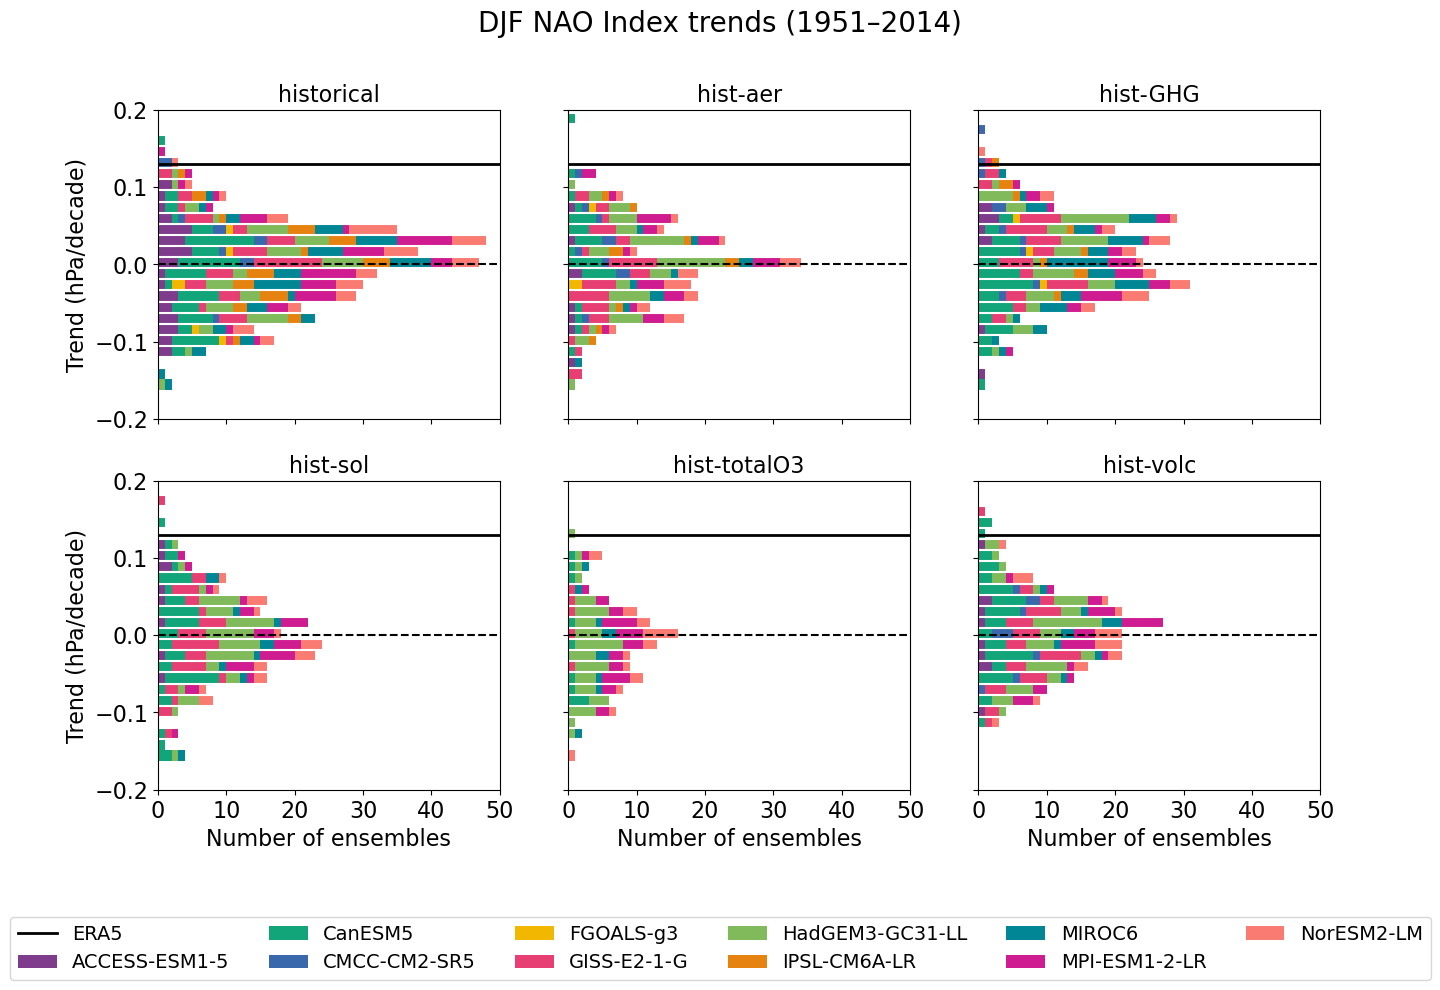

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
bin_width = None

for idx, exp in enumerate(experiment):
    row = idx // 3
    col = idx % 3
    
    ax_curr = ax[row, col]
    
    # Extract data
    data = experiment_hist_data[exp]
    hist_data = data['hist_data']
    bin_edges = data['bin_edges']
    models = data['models']
    colors = experiment_colours[exp]
    
    # Initialize bin width
    if bin_width is None:
        bin_width = np.abs(bin_edges[1] - bin_edges[0])

    # Stacked horizontal bar plot
    for i in range(len(hist_data)):
        left = hist_data[:i].sum(axis=0)
        ax_curr.barh(bin_edges[:-1], hist_data[i], height=np.diff(bin_edges),
                     left=left, color=colors[i], label=models[i])
    
    # Grid lines between bins
    for i in range(1, len(bin_edges)):
        ax_curr.axhline(bin_edges[i] + bin_width / 2, color='white')
    
    # ERA5 line
    ax_curr.axhline(era5_trend_PDF.item(), color='black', linewidth=2, label='ERA5')
    
    # Formatting
    ax_curr.axhline(0, color='black', linestyle='--')
    ax_curr.set_xlim(0, 50)
    ax_curr.tick_params(labelsize=16)
    ax_curr.set_title(f'{exp}', fontsize=16)
    ax_curr.set_ylim(-0.2,0.2)
    if row == 1:
        ax_curr.set_xlabel('Number of ensembles', fontsize = 16)
    else:
        ax_curr.set_xticklabels([])
    if col == 0:
        ax_curr.set_ylabel('Trend (hPa/decade)', fontsize=16)
    else:
        ax_curr.set_yticklabels([])
        

# Add shared legend below
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=6, fontsize=14)

plt.suptitle('DJF NAO Index trends (1951–2014)', fontsize=20)
plt.subplots_adjust(top=0.88, bottom=0.2)
plt.savefig('NAO_community_paper_plots_updated_projection_methodology/NAO_trends_1951-2014_all_experiments.png', bbox_inches='tight')
plt.show()

